# TaniFi QLoRA Analysis Notebook

This notebook analyzes the results from 3 experiment scenarios with QLoRA adapters for the research paper.

**Paper Title:** Simulation of Bandwidth-Efficient Federated Learning Architectures for Resource-Constrained Agricultural Networks in Indonesia

## Scenarios:
1. **Centralized + QLoRA** — Baseline: single model trained on all data
2. **FedAvg + QLoRA** — Federated: 10 farmers, 200 rounds, 50 local steps (frequent sync)
3. **DiLoCo + QLoRA** — Federated: 10 farmers, 20 rounds, 500 local steps (rare sync)

## Sections:
1. Setup & Imports
2. Load All 3 Scenario Results
3. 3-Way Comparison Table (Paper's Headline Result)
4. Convergence Curves (Overlaid)
5. Bandwidth Efficiency Analysis
6. Training Time Analysis
7. Comprehensive Paper-Ready Figure
8. Export LaTeX Tables

## 1. Setup & Imports

In [1]:
import sys
print(sys.executable)

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for paper-quality plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('husl')

# Configure matplotlib for better quality
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 6)

# Scenario colors (consistent across all plots)
COLORS = {
    'centralized': '#2E86AB',   # Blue
    'fedavg': '#F18F01',        # Orange
    'diloco': '#C73E1D',        # Red
}
LABELS = {
    'centralized': 'Centralized + QLoRA',
    'fedavg': 'FedAvg + QLoRA (200r/50s)',
    'diloco': 'DiLoCo + QLoRA (20r/500s)',
}

# Results directory
results_dir = Path('../experiments/results')
plots_dir = results_dir / 'plots'
tables_dir = results_dir / 'tables'
plots_dir.mkdir(parents=True, exist_ok=True)
tables_dir.mkdir(parents=True, exist_ok=True)

print(f'Results dir: {results_dir.resolve()}')
print('Libraries loaded successfully')

/home/karel/code/TaniFi/venv/bin/python
Results dir: /home/karel/code/TaniFi/experiments/results
Libraries loaded successfully


## 2. Load All 3 Scenario Results

In [2]:
# --- Helper: load the latest JSON matching a pattern ---
def load_latest_json(pattern):
    files = sorted(results_dir.glob(pattern))
    if not files:
        return None, None
    path = files[-1]  # latest by timestamp suffix
    with open(path, 'r') as f:
        return json.load(f), path.name

# --- Helper: classify a federated result as 'fedavg' or 'diloco' ---
def classify_federated(data):
    """Determine if a federated result is FedAvg-style or DiLoCo-style."""
    exp_name = data.get('config', {}).get('experiment', {}).get('name', '')
    if 'fedavg' in exp_name.lower():
        return 'fedavg'
    if 'diloco' in exp_name.lower():
        return 'diloco'
    # Fallback: classify by local_steps
    fed_cfg = data.get('config', {}).get('federated', {})
    local_steps = fed_cfg.get('local_steps', data.get('config', {}).get('local_steps', 0))
    return 'fedavg' if local_steps <= 100 else 'diloco'

# =================================================================
# Load Centralized + QLoRA
# =================================================================
centralized_data, centralized_file = load_latest_json('centralized_baseline_*.json')
if centralized_data:
    print(f'✅ Centralized loaded: {centralized_file}')
    print(f'   Adapter: {centralized_data.get("adapter_type", "N/A")}')
    print(f'   Test Accuracy: {centralized_data["test_metrics"]["accuracy"]:.4f}')
    print(f'   Test F1:       {centralized_data["test_metrics"]["f1_macro"]:.4f}')
else:
    print('❌ No centralized results found!')

# =================================================================
# Load Federated results and classify as FedAvg / DiLoCo
# =================================================================
fedavg_data = None
diloco_data = None
fedavg_file = None
diloco_file = None

fed_files = sorted(results_dir.glob('federated_diLoCo_*.json'))
print(f'\nFound {len(fed_files)} federated result files')

for fpath in fed_files:
    with open(fpath, 'r') as f:
        data = json.load(f)
    scenario = classify_federated(data)
    if scenario == 'fedavg':
        fedavg_data, fedavg_file = data, fpath.name
    elif scenario == 'diloco':
        diloco_data, diloco_file = data, fpath.name

if fedavg_data:
    print(f'✅ FedAvg loaded: {fedavg_file}')
    fed_cfg = fedavg_data['config'].get('federated', {})
    print(f'   Config: {fed_cfg.get("num_farmers", "?")} farmers, '
          f'{fed_cfg.get("num_rounds", "?")} rounds, '
          f'{fed_cfg.get("local_steps", "?")} steps')
else:
    print('❌ No FedAvg results found!')

if diloco_data:
    print(f'✅ DiLoCo loaded: {diloco_file}')
    fed_cfg = diloco_data['config'].get('federated', {})
    print(f'   Config: {fed_cfg.get("num_farmers", "?")} farmers, '
          f'{fed_cfg.get("num_rounds", "?")} rounds, '
          f'{fed_cfg.get("local_steps", "?")} steps')
else:
    print('❌ No DiLoCo results found!')

# Quick summary
print(f'\n{"="*60}')
loaded = sum(1 for d in [centralized_data, fedavg_data, diloco_data] if d is not None)
print(f'Loaded {loaded}/3 scenarios')

✅ Centralized loaded: centralized_baseline_20260220_071421.json
   Adapter: qlora
   Test Accuracy: 0.3182
   Test F1:       0.3191

Found 5 federated result files
✅ FedAvg loaded: federated_diLoCo_20260220_151946.json
   Config: 10 farmers, 200 rounds, 50 steps
✅ DiLoCo loaded: federated_diLoCo_20260220_232328.json
   Config: 10 farmers, 20 rounds, 500 steps

Loaded 3/3 scenarios


## 3. 3-Way Comparison Table (Paper's Headline Result)

3-Way Scenario Comparison:


,Metric,Centralized + QLoRA,FedAvg + QLoRA (200r/50s),DiLoCo + QLoRA (20r/500s)
0,Final Train Loss,1.0950,0.5157,0.5011
1,Val Accuracy,0.2917,0.8542,0.8750
2,Val F1 (macro),0.2500,0.6824,0.7786
3,Test Accuracy,0.3182,N/A,N/A
4,Test F1 (macro),0.3191,N/A,N/A
5,Bandwidth Saved (%),0.00,99.91,99.91


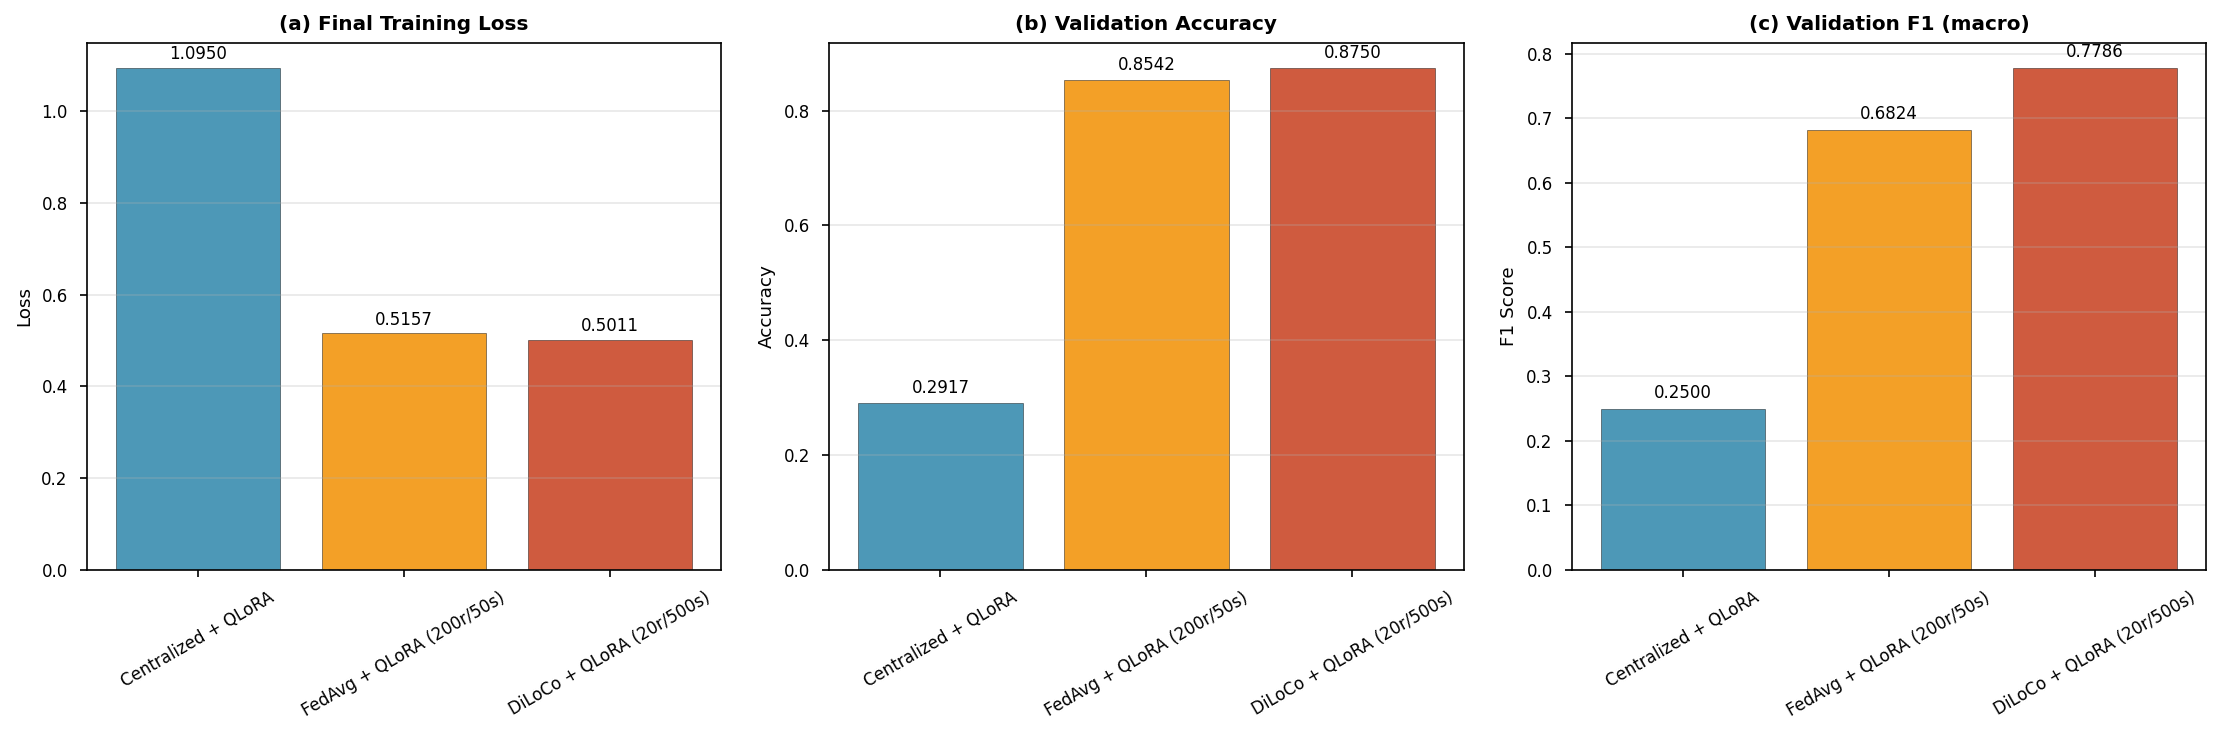

3-way comparison saved!


In [3]:
# --- Extract metrics into a comparison DataFrame ---
def get_centralized_metrics(data):
    if data is None:
        return {k: None for k in ['final_loss', 'val_acc', 'val_f1', 'test_acc', 'test_f1', 'bw_saved']}
    h = data['history']
    t = data['test_metrics']
    return {
        'final_loss': h['train_loss'][-1] if h['train_loss'] else None,
        'val_acc': h['val_acc'][-1] if h.get('val_acc') else None,
        'val_f1': h['val_f1'][-1] if h.get('val_f1') else None,
        'test_acc': t.get('accuracy'),
        'test_f1': t.get('f1_macro'),
        'bw_saved': 0.0,  # baseline
    }

def get_federated_metrics(data):
    if data is None:
        return {k: None for k in ['final_loss', 'val_acc', 'val_f1', 'test_acc', 'test_f1', 'bw_saved']}
    m = data['metrics']
    return {
        'final_loss': m['avg_loss'][-1] if m.get('avg_loss') else None,
        'val_acc': m['val_accuracy'][-1] if m.get('val_accuracy') else None,
        'val_f1': m['val_f1_macro'][-1] if m.get('val_f1_macro') else None,
        'test_acc': None,  # federated test is via coordinator.evaluate_final
        'test_f1': None,
        'bw_saved': np.mean(m.get('bandwidth_saved', [0])),
    }

c_m = get_centralized_metrics(centralized_data)
f_m = get_federated_metrics(fedavg_data)
d_m = get_federated_metrics(diloco_data)

metrics_list = ['Final Train Loss', 'Val Accuracy', 'Val F1 (macro)',
                'Test Accuracy', 'Test F1 (macro)', 'Bandwidth Saved (%)']
keys = ['final_loss', 'val_acc', 'val_f1', 'test_acc', 'test_f1', 'bw_saved']

def fmt(v, is_pct=False):
    if v is None:
        return 'N/A'
    return f'{v:.2f}' if is_pct else f'{v:.4f}'

comparison_df = pd.DataFrame({
    'Metric': metrics_list,
    LABELS['centralized']: [fmt(c_m[k], k == 'bw_saved') for k in keys],
    LABELS['fedavg']:      [fmt(f_m[k], k == 'bw_saved') for k in keys],
    LABELS['diloco']:      [fmt(d_m[k], k == 'bw_saved') for k in keys],
})

print('3-Way Scenario Comparison:')
display(comparison_df)

# --- Bar chart comparison ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scenarios = ['centralized', 'fedavg', 'diloco']
all_metrics = [c_m, f_m, d_m]

for ax, metric_key, title, ylabel in [
    (axes[0], 'final_loss', '(a) Final Training Loss', 'Loss'),
    (axes[1], 'val_acc', '(b) Validation Accuracy', 'Accuracy'),
    (axes[2], 'val_f1', '(c) Validation F1 (macro)', 'F1 Score'),
]:
    values = [m.get(metric_key, 0) or 0 for m in all_metrics]
    bars = ax.bar(
        [LABELS[s] for s in scenarios],
        values,
        color=[COLORS[s] for s in scenarios],
        edgecolor='black', alpha=0.85
    )
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=8)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_dir / '3way_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('3-way comparison saved!')

## 4. Convergence Curves (Overlaid)

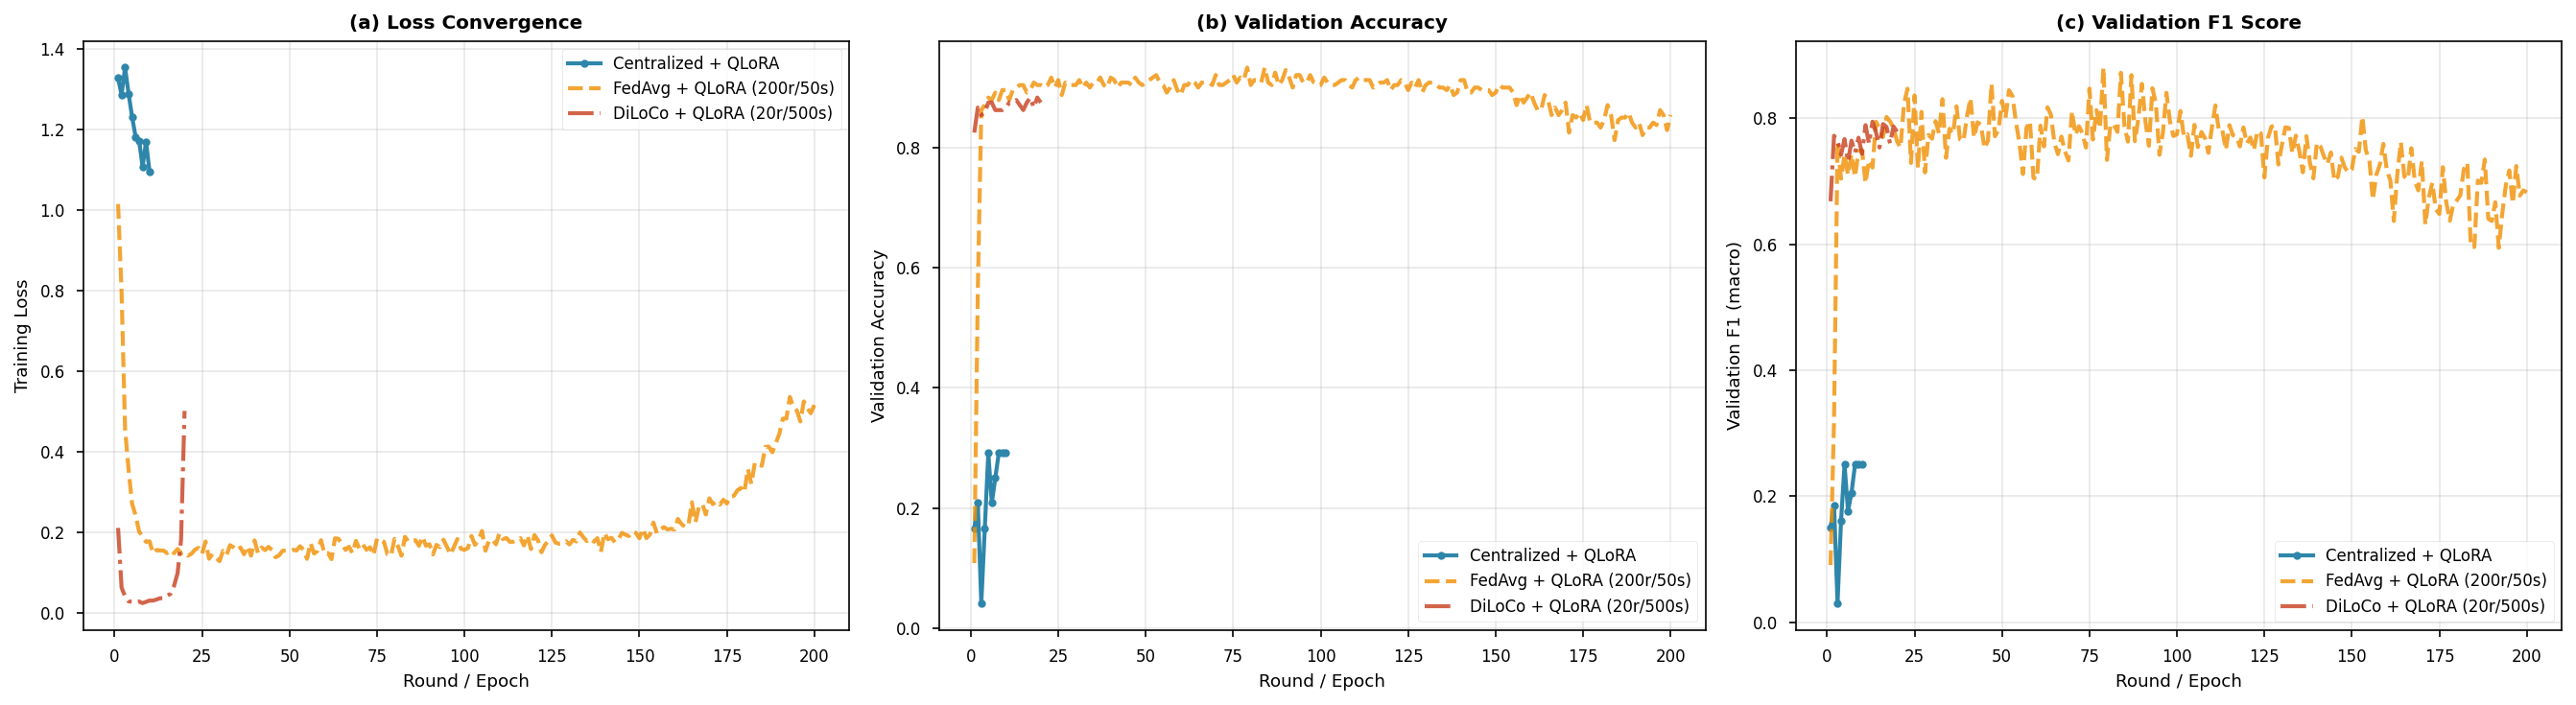

Convergence curves saved!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- (a) Loss convergence ---
ax = axes[0]
if centralized_data:
    epochs = range(1, len(centralized_data['history']['train_loss']) + 1)
    ax.plot(epochs, centralized_data['history']['train_loss'],
            color=COLORS['centralized'], label=LABELS['centralized'],
            linewidth=2, linestyle='-', marker='o', markersize=4)
if fedavg_data:
    rounds_f = range(1, len(fedavg_data['metrics']['avg_loss']) + 1)
    ax.plot(rounds_f, fedavg_data['metrics']['avg_loss'],
            color=COLORS['fedavg'], label=LABELS['fedavg'],
            linewidth=2, linestyle='--', alpha=0.8)
if diloco_data:
    rounds_d = range(1, len(diloco_data['metrics']['avg_loss']) + 1)
    ax.plot(rounds_d, diloco_data['metrics']['avg_loss'],
            color=COLORS['diloco'], label=LABELS['diloco'],
            linewidth=2, linestyle='-.', alpha=0.8)
ax.set_xlabel('Round / Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('(a) Loss Convergence', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- (b) Validation Accuracy ---
ax = axes[1]
if centralized_data and centralized_data['history'].get('val_acc'):
    epochs = range(1, len(centralized_data['history']['val_acc']) + 1)
    ax.plot(epochs, centralized_data['history']['val_acc'],
            color=COLORS['centralized'], label=LABELS['centralized'],
            linewidth=2, linestyle='-', marker='o', markersize=4)
if fedavg_data and fedavg_data['metrics'].get('val_accuracy'):
    rounds_f = range(1, len(fedavg_data['metrics']['val_accuracy']) + 1)
    ax.plot(rounds_f, fedavg_data['metrics']['val_accuracy'],
            color=COLORS['fedavg'], label=LABELS['fedavg'],
            linewidth=2, linestyle='--', alpha=0.8)
if diloco_data and diloco_data['metrics'].get('val_accuracy'):
    rounds_d = range(1, len(diloco_data['metrics']['val_accuracy']) + 1)
    ax.plot(rounds_d, diloco_data['metrics']['val_accuracy'],
            color=COLORS['diloco'], label=LABELS['diloco'],
            linewidth=2, linestyle='-.', alpha=0.8)
ax.set_xlabel('Round / Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('(b) Validation Accuracy', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- (c) Validation F1 ---
ax = axes[2]
if centralized_data and centralized_data['history'].get('val_f1'):
    epochs = range(1, len(centralized_data['history']['val_f1']) + 1)
    ax.plot(epochs, centralized_data['history']['val_f1'],
            color=COLORS['centralized'], label=LABELS['centralized'],
            linewidth=2, linestyle='-', marker='o', markersize=4)
if fedavg_data and fedavg_data['metrics'].get('val_f1_macro'):
    rounds_f = range(1, len(fedavg_data['metrics']['val_f1_macro']) + 1)
    ax.plot(rounds_f, fedavg_data['metrics']['val_f1_macro'],
            color=COLORS['fedavg'], label=LABELS['fedavg'],
            linewidth=2, linestyle='--', alpha=0.8)
if diloco_data and diloco_data['metrics'].get('val_f1_macro'):
    rounds_d = range(1, len(diloco_data['metrics']['val_f1_macro']) + 1)
    ax.plot(rounds_d, diloco_data['metrics']['val_f1_macro'],
            color=COLORS['diloco'], label=LABELS['diloco'],
            linewidth=2, linestyle='-.', alpha=0.8)
ax.set_xlabel('Round / Epoch')
ax.set_ylabel('Validation F1 (macro)')
ax.set_title('(c) Validation F1 Score', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'convergence_overlay.png', dpi=300, bbox_inches='tight')
plt.show()
print('Convergence curves saved!')

## 5. Bandwidth Efficiency Analysis

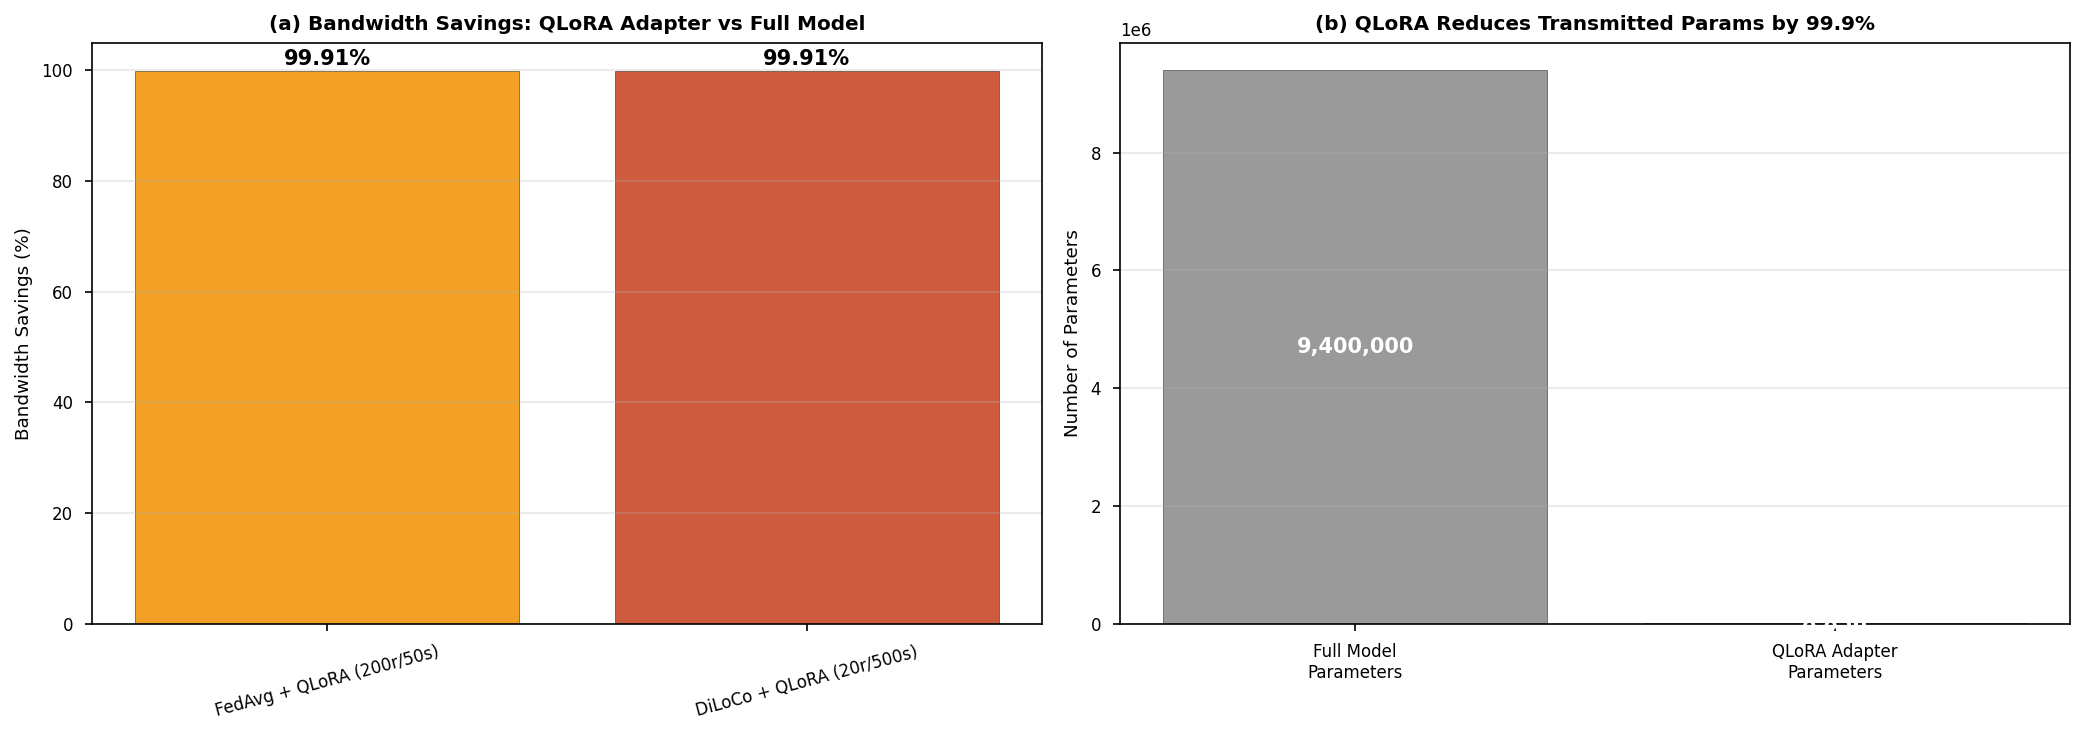

Bandwidth analysis saved!


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- (a) Bandwidth savings bar chart ---
ax = axes[0]
bw_data = {}
if fedavg_data and fedavg_data['metrics'].get('bandwidth_saved'):
    bw_data['fedavg'] = np.mean(fedavg_data['metrics']['bandwidth_saved'])
if diloco_data and diloco_data['metrics'].get('bandwidth_saved'):
    bw_data['diloco'] = np.mean(diloco_data['metrics']['bandwidth_saved'])

if bw_data:
    bars = ax.bar(
        [LABELS[k] for k in bw_data.keys()],
        list(bw_data.values()),
        color=[COLORS[k] for k in bw_data.keys()],
        edgecolor='black', alpha=0.85
    )
    for bar, val in zip(bars, bw_data.values()):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                f'{val:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.set_ylabel('Bandwidth Savings (%)')
    ax.set_title('(a) Bandwidth Savings: QLoRA Adapter vs Full Model', fontweight='bold')
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
else:
    ax.text(0.5, 0.5, 'No bandwidth data available', ha='center', va='center',
            transform=ax.transAxes, fontsize=12)
    ax.set_title('(a) Bandwidth Savings')

# --- (b) Adapter vs Full Model parameter count ---
ax = axes[1]
# Try to extract param counts from bandwidth_saved ratio
# bandwidth_saved = (1 - shard/full) * 100 => shard/full = 1 - bw/100
param_info = {}
for key, data in [('fedavg', fedavg_data), ('diloco', diloco_data)]:
    if data and data['metrics'].get('bandwidth_saved'):
        bw = data['metrics']['bandwidth_saved'][0]  # ratio is constant
        ratio = 1.0 - bw/100.0
        param_info[key] = {'ratio': ratio, 'bw_pct': bw}

if param_info:
    # Use first available
    first_key = list(param_info.keys())[0]
    ratio = param_info[first_key]['ratio']
    # YOLOv11 Small has ~9.4M params, adapter is ratio * full
    full_params = 9_400_000  # approximate for yolo11s-cls
    adapter_params = int(full_params * ratio)
    
    bars = ax.bar(
        ['Full Model\nParameters', 'QLoRA Adapter\nParameters'],
        [full_params, adapter_params],
        color=['#888888', '#2ECC71'],
        edgecolor='black', alpha=0.85
    )
    for bar, val in zip(bars, [full_params, adapter_params]):
        label = f'{val:,}' if val > 1000 else str(val)
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() * 0.5,
                label, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    ax.set_ylabel('Number of Parameters')
    ax.set_title(f'(b) QLoRA Reduces Transmitted Params by {param_info[first_key]["bw_pct"]:.1f}%',
                 fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No parameter data available', ha='center', va='center',
            transform=ax.transAxes, fontsize=12)
    ax.set_title('(b) Parameter Comparison')

plt.tight_layout()
plt.savefig(plots_dir / 'bandwidth_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print('Bandwidth analysis saved!')

## 6. Training Time Analysis

Training Time Analysis



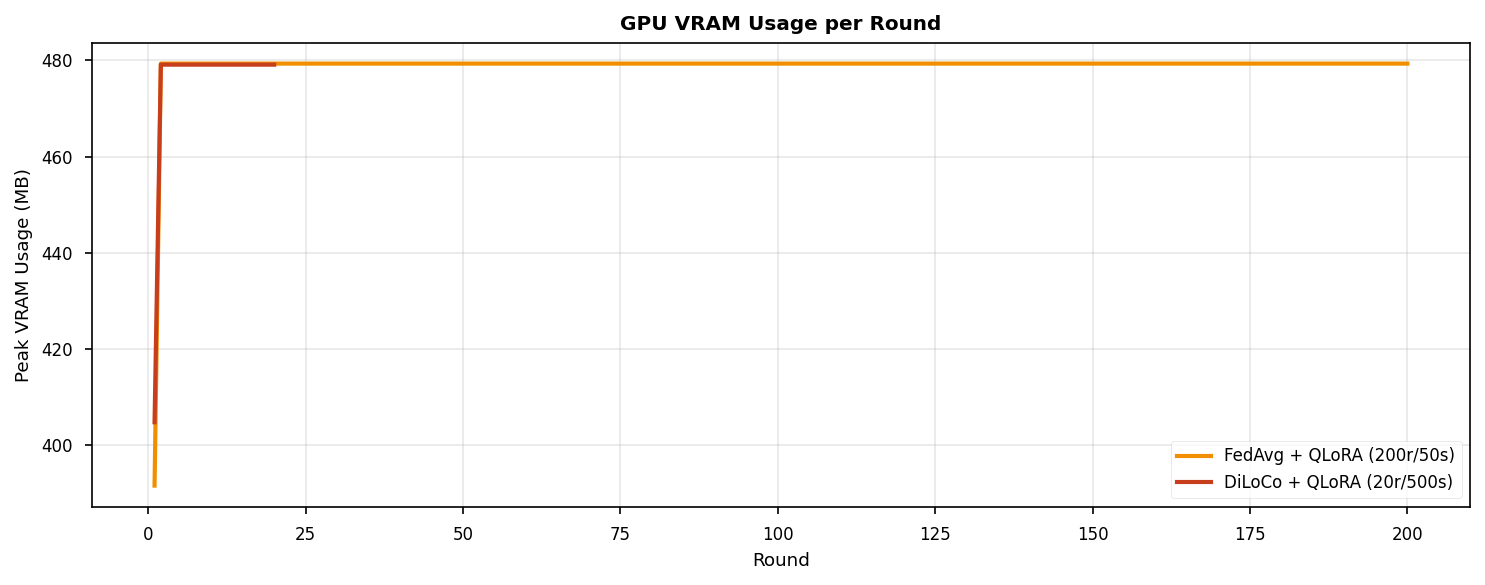

FedAvg + QLoRA (200r/50s):
  Peak VRAM: 479.3 MB
  Avg VRAM:  478.9 MB
DiLoCo + QLoRA (20r/500s):
  Peak VRAM: 479.1 MB
  Avg VRAM:  475.4 MB


In [6]:
# Note: Training time comparison requires timestamp data from the result files.
# The current result format stores timestamps but not total training duration.
# This section will be populated when timing data is available.

print('Training Time Analysis')
print('=' * 60)
print()

# Check for VRAM usage data (available in federated results)
vram_data = {}
for key, data in [('fedavg', fedavg_data), ('diloco', diloco_data)]:
    if data and data['metrics'].get('vram_mb'):
        vram_data[key] = data['metrics']['vram_mb']

if vram_data:
    fig, ax = plt.subplots(figsize=(10, 4))
    for key, vram in vram_data.items():
        rounds = range(1, len(vram) + 1)
        ax.plot(rounds, vram, color=COLORS[key], label=LABELS[key], linewidth=2)
    ax.set_xlabel('Round')
    ax.set_ylabel('Peak VRAM Usage (MB)')
    ax.set_title('GPU VRAM Usage per Round', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'vram_usage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    for key, vram in vram_data.items():
        print(f'{LABELS[key]}:')
        print(f'  Peak VRAM: {max(vram):.1f} MB')
        print(f'  Avg VRAM:  {np.mean(vram):.1f} MB')
else:
    print('No VRAM usage data available in the current results.')
    print('This data will be available after running the federated experiments.')

## 7. Comprehensive Paper-Ready Figure

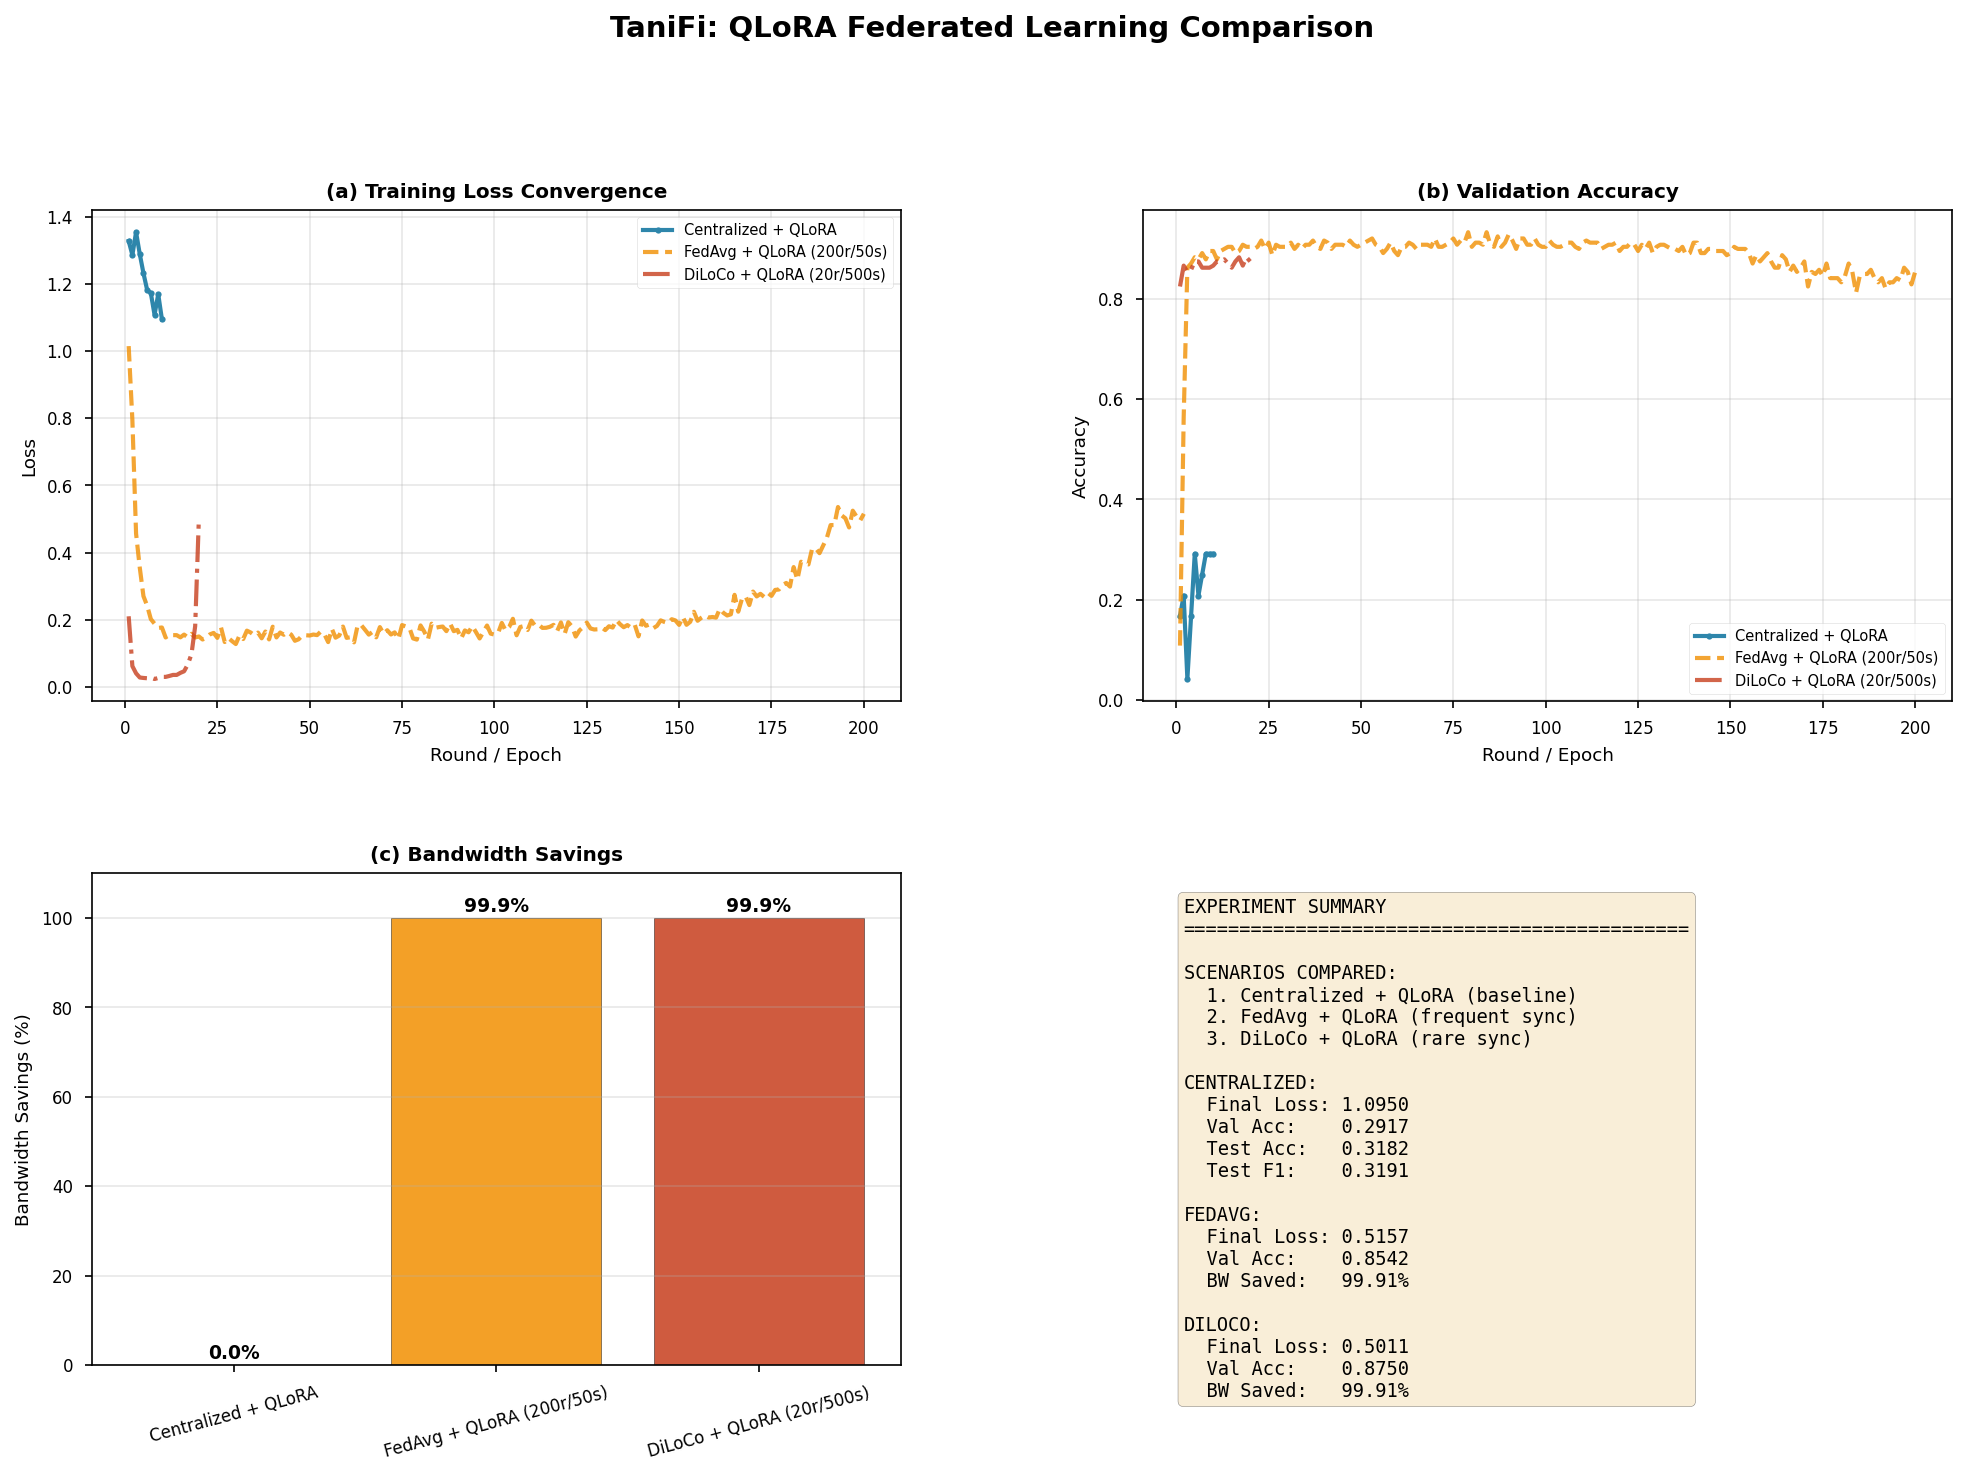

Comprehensive paper figure saved!


In [7]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.3)

# --- (a) Loss convergence overlay ---
ax1 = fig.add_subplot(gs[0, 0])
if centralized_data:
    epochs = range(1, len(centralized_data['history']['train_loss']) + 1)
    ax1.plot(epochs, centralized_data['history']['train_loss'],
             color=COLORS['centralized'], label=LABELS['centralized'],
             linewidth=2, marker='o', markersize=3)
if fedavg_data and fedavg_data['metrics'].get('avg_loss'):
    r = range(1, len(fedavg_data['metrics']['avg_loss']) + 1)
    ax1.plot(r, fedavg_data['metrics']['avg_loss'],
             color=COLORS['fedavg'], label=LABELS['fedavg'],
             linewidth=2, linestyle='--', alpha=0.8)
if diloco_data and diloco_data['metrics'].get('avg_loss'):
    r = range(1, len(diloco_data['metrics']['avg_loss']) + 1)
    ax1.plot(r, diloco_data['metrics']['avg_loss'],
             color=COLORS['diloco'], label=LABELS['diloco'],
             linewidth=2, linestyle='-.', alpha=0.8)
ax1.set_xlabel('Round / Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('(a) Training Loss Convergence', fontweight='bold')
ax1.legend(fontsize=7)
ax1.grid(True, alpha=0.3)

# --- (b) Accuracy convergence overlay ---
ax2 = fig.add_subplot(gs[0, 1])
if centralized_data and centralized_data['history'].get('val_acc'):
    epochs = range(1, len(centralized_data['history']['val_acc']) + 1)
    ax2.plot(epochs, centralized_data['history']['val_acc'],
             color=COLORS['centralized'], label=LABELS['centralized'],
             linewidth=2, marker='o', markersize=3)
if fedavg_data and fedavg_data['metrics'].get('val_accuracy'):
    r = range(1, len(fedavg_data['metrics']['val_accuracy']) + 1)
    ax2.plot(r, fedavg_data['metrics']['val_accuracy'],
             color=COLORS['fedavg'], label=LABELS['fedavg'],
             linewidth=2, linestyle='--', alpha=0.8)
if diloco_data and diloco_data['metrics'].get('val_accuracy'):
    r = range(1, len(diloco_data['metrics']['val_accuracy']) + 1)
    ax2.plot(r, diloco_data['metrics']['val_accuracy'],
             color=COLORS['diloco'], label=LABELS['diloco'],
             linewidth=2, linestyle='-.', alpha=0.8)
ax2.set_xlabel('Round / Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('(b) Validation Accuracy', fontweight='bold')
ax2.legend(fontsize=7)
ax2.grid(True, alpha=0.3)

# --- (c) Bandwidth savings ---
ax3 = fig.add_subplot(gs[1, 0])
bw_labels = []
bw_values = []
bw_colors = []
for key, data in [('centralized', centralized_data), ('fedavg', fedavg_data), ('diloco', diloco_data)]:
    if data:
        if key == 'centralized':
            bw_labels.append(LABELS[key])
            bw_values.append(0.0)
            bw_colors.append(COLORS[key])
        elif data['metrics'].get('bandwidth_saved'):
            bw_labels.append(LABELS[key])
            bw_values.append(np.mean(data['metrics']['bandwidth_saved']))
            bw_colors.append(COLORS[key])

if bw_values:
    bars = ax3.bar(bw_labels, bw_values, color=bw_colors, edgecolor='black', alpha=0.85)
    for bar, val in zip(bars, bw_values):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax3.set_ylabel('Bandwidth Savings (%)')
    ax3.set_title('(c) Bandwidth Savings', fontweight='bold')
    ax3.set_ylim(0, 110)
    ax3.tick_params(axis='x', rotation=15)
    ax3.grid(True, alpha=0.3, axis='y')

# --- (d) Summary text ---
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_lines = ['EXPERIMENT SUMMARY', '=' * 45, '']
summary_lines.append('SCENARIOS COMPARED:')
summary_lines.append('  1. Centralized + QLoRA (baseline)')
summary_lines.append('  2. FedAvg + QLoRA (frequent sync)')
summary_lines.append('  3. DiLoCo + QLoRA (rare sync)')
summary_lines.append('')

if centralized_data:
    summary_lines.append('CENTRALIZED:')
    summary_lines.append(f'  Final Loss: {c_m["final_loss"]:.4f}')
    summary_lines.append(f'  Val Acc:    {(c_m["val_acc"] or 0):.4f}')
    summary_lines.append(f'  Test Acc:   {(c_m["test_acc"] or 0):.4f}')
    summary_lines.append(f'  Test F1:    {(c_m["test_f1"] or 0):.4f}')
    summary_lines.append('')

if fedavg_data:
    summary_lines.append('FEDAVG:')
    summary_lines.append(f'  Final Loss: {f_m["final_loss"]:.4f}')
    summary_lines.append(f'  Val Acc:    {(f_m["val_acc"] or 0):.4f}')
    summary_lines.append(f'  BW Saved:   {f_m["bw_saved"]:.2f}%')
    summary_lines.append('')

if diloco_data:
    summary_lines.append('DILOCO:')
    summary_lines.append(f'  Final Loss: {d_m["final_loss"]:.4f}')
    summary_lines.append(f'  Val Acc:    {(d_m["val_acc"] or 0):.4f}')
    summary_lines.append(f'  BW Saved:   {d_m["bw_saved"]:.2f}%')

summary_text = '\n'.join(summary_lines)
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('TaniFi: QLoRA Federated Learning Comparison',
             fontsize=14, fontweight='bold', y=1.01)
plt.savefig(plots_dir / 'paper_figure_3way.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print('Comprehensive paper figure saved!')

## 8. Export LaTeX Tables for Paper

In [8]:
# --- Helper: wrap LaTeX table in a compilable document ---
def latex_doc(title, content):
    return f"""% {title}
% Generated automatically by TaniFi analysis notebook

\\documentclass{{article}}
\\usepackage{{booktabs}}
\\usepackage[margin=1in]{{geometry}}
\\begin{{document}}

% === COPY START ===

{content}

% === COPY END ===

\\end{{document}}
"""

# =====================================================================
# Table 1: 3-Way Comparison
# =====================================================================
def esc(v):
    """Escape % for LaTeX."""
    if isinstance(v, str):
        return v.replace('%', '\\%')
    return v

metrics_for_latex = [
    ('Final Train Loss', 'final_loss', False),
    ('Val Accuracy',     'val_acc',    False),
    ('Val F1 (macro)',   'val_f1',     False),
    ('Test Accuracy',    'test_acc',   False),
    ('Test F1 (macro)',  'test_f1',    False),
    ('Bandwidth Saved (\\%)', 'bw_saved', True),
]

rows = []
for label, key, is_pct in metrics_for_latex:
    c_val = fmt(c_m.get(key), is_pct)
    f_val = fmt(f_m.get(key), is_pct)
    d_val = fmt(d_m.get(key), is_pct)
    rows.append(f'{label} & {c_val} & {f_val} & {d_val} \\\\')

table_3way = f"""\\begin{{table}}[h]
\\centering
\\caption{{Comparison of 3 QLoRA Training Scenarios}}
\\label{{tab:3way_comparison}}
\\begin{{tabular}}{{lrrr}}
\\toprule
Metric & Centralized & FedAvg & DiLoCo \\\\
\\midrule
{chr(10).join(rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / '3way_comparison.tex', 'w') as f:
    f.write(latex_doc('3-Way Comparison', table_3way))

# =====================================================================
# Table 2: Detailed Federated Configuration
# =====================================================================
fed_rows = []
for key, data, label in [('fedavg', fedavg_data, 'FedAvg'), ('diloco', diloco_data, 'DiLoCo')]:
    if data:
        cfg = data['config'].get('federated', {})
        m = get_federated_metrics(data)
        fed_rows.append(
            f'{label} & {cfg.get("num_farmers", "?")} & '
            f'{cfg.get("num_rounds", "?")} & '
            f'{cfg.get("local_steps", "?")} & '
            f'{fmt(m["final_loss"])} & '
            f'{fmt(m["val_acc"])} & '
            f'{fmt(m["bw_saved"], True)} \\\\'
        )

if fed_rows:
    table_fed = f"""\\begin{{table}}[h]
\\centering
\\caption{{Detailed Federated Experiment Configurations}}
\\label{{tab:federated_details}}
\\begin{{tabular}}{{lrrrrrr}}
\\toprule
Scenario & Farmers & Rounds & Steps & Final Loss & Val Acc & BW Saved (\\%) \\\\
\\midrule
{chr(10).join(fed_rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""
    with open(tables_dir / 'federated_details.tex', 'w') as f:
        f.write(latex_doc('Federated Details', table_fed))

# =====================================================================
# Table 3: Overall Summary
# =====================================================================
summary_rows = [
    f'Training Scenarios & 3 (Centralized, FedAvg, DiLoCo) \\\\',
    f'Adapter Type & QLoRA (4-bit NF4) \\\\',
    f'Base Model & YOLOv11 Small (yolo11s-cls) \\\\',
]
if fedavg_data:
    cfg = fedavg_data['config'].get('federated', {})
    summary_rows.append(f'FedAvg Config & {cfg.get("num_farmers","?")}f / {cfg.get("num_rounds","?")}r / {cfg.get("local_steps","?")}s \\\\')
if diloco_data:
    cfg = diloco_data['config'].get('federated', {})
    summary_rows.append(f'DiLoCo Config & {cfg.get("num_farmers","?")}f / {cfg.get("num_rounds","?")}r / {cfg.get("local_steps","?")}s \\\\')
if bw_data:
    avg_bw = np.mean(list(bw_data.values()))
    summary_rows.append(f'Avg Bandwidth Savings & {avg_bw:.2f}\\% \\\\')

summary_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{TaniFi QLoRA Experiment Summary}}
\\label{{tab:experiment_summary}}
\\begin{{tabular}}{{ll}}
\\toprule
Property & Value \\\\
\\midrule
{chr(10).join(summary_rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / 'experiment_summary.tex', 'w') as f:
    f.write(latex_doc('Experiment Summary', summary_table))

print(f'LaTeX tables saved to: {tables_dir}')
for f in sorted(tables_dir.glob('*.tex')):
    print(f'  - {f.name}')

LaTeX tables saved to: ../experiments/results/tables
  - 3way_comparison.tex
  - experiment_summary.tex
  - federated_details.tex
